In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('steam_data.csv', index_col=0)

# Exploratory Data Analysis

## Data Quality

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65521 entries, 3057270 to 1580420
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             65521 non-null  object 
 1   release_year     65521 non-null  int64  
 2   release_date     65521 non-null  object 
 3   genres           65455 non-null  object 
 4   categories       65514 non-null  object 
 5   price            65521 non-null  float64
 6   recommendations  65521 non-null  int64  
 7   developer        65468 non-null  object 
 8   publisher        65338 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 5.0+ MB


In [4]:
df.describe()

,release_year,price,recommendations
count,65521.000000,65521.000000,65521.000000
mean,2023.453091,7.204043,362.165336
std,1.386641,16.914429,6936.837198
min,2021.000000,0.000000,0.000000
25%,2022.000000,0.990000,0.000000
50%,2024.000000,3.990000,0.000000
75%,2025.000000,9.740000,0.000000
max,2025.000000,1900.000000,862487.000000


In [5]:
df.isna().sum()

name                 0
release_year         0
release_date         0
genres              66
categories           7
price                0
recommendations      0
developer           53
publisher          183
dtype: int64

In [6]:
df.genres = df.genres.fillna('N/A')
df.categories = df.categories.fillna('N/A')
df.developer = df.developer.fillna('N/A')
df.publisher = df.publisher.fillna('N/A')

## Target Variable Analysis

In [7]:
df["recommendations"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

count     65521.000000
mean        362.165336
std        6936.837198
min           0.000000
50%           0.000000
75%           0.000000
90%         145.000000
95%         476.000000
99%        4664.000000
max      862487.000000
Name: recommendations, dtype: float64

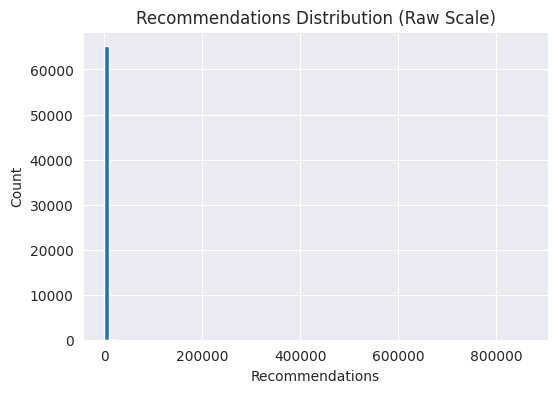

In [8]:
sns.set_style("darkgrid")

plt.figure(figsize=(6, 4))
plt.hist(df["recommendations"], bins=100)
plt.title("Recommendations Distribution (Raw Scale)")
plt.xlabel("Recommendations")
plt.ylabel("Count")
plt.show()

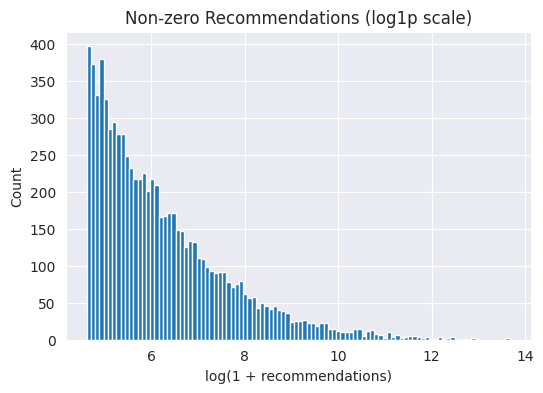

In [9]:
non_zero = df[df["recommendations"] > 0]["recommendations"]

plt.figure(figsize=(6, 4))
plt.hist(np.log1p(non_zero), bins=100)
plt.title("Non-zero Recommendations (log1p scale)")
plt.xlabel("log(1 + recommendations)")
plt.ylabel("Count")
plt.show()

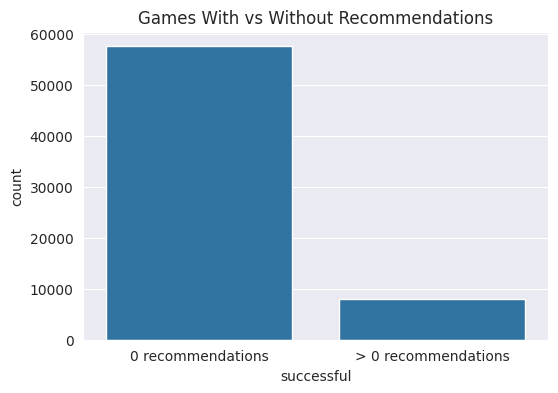

In [10]:
df["successful"] = (df["recommendations"] > 0).astype(int)

plt.figure(figsize=(6, 4))
sns.countplot(x="successful", data=df)
plt.title("Games With vs Without Recommendations")
plt.xticks([0, 1], ["0 recommendations", "> 0 recommendations"])
plt.show()


In [11]:
print(df["successful"].value_counts(normalize=True))

successful
0    0.87781
1    0.12219
Name: proportion, dtype: float64


## Price Analysis

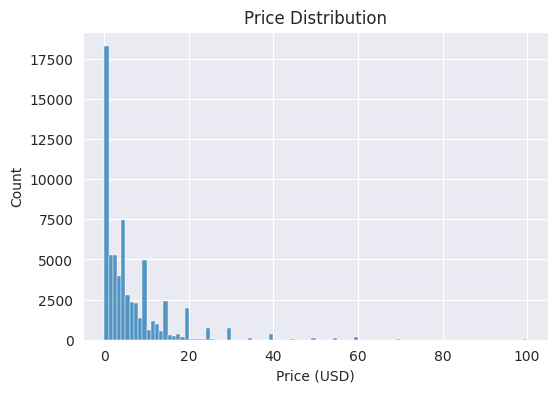

In [12]:
df_plot = df[df["price"] <= 100]
plt.figure(figsize=(6, 4))
sns.histplot(df_plot["price"], bins=100)
plt.title("Price Distribution")
plt.xlabel("Price (USD)")
plt.show()

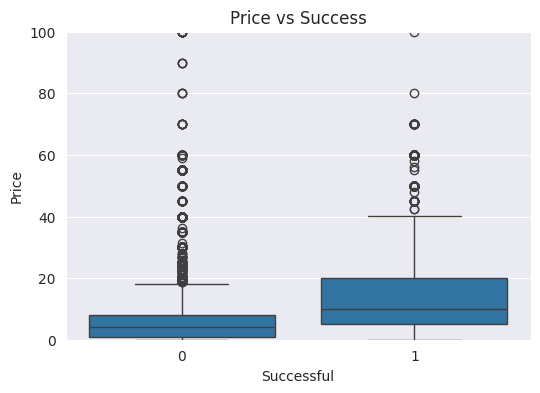

In [13]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="successful", y="price", data=df)
plt.ylim(0,100)
plt.title("Price vs Success")
plt.xlabel("Successful")
plt.ylabel("Price")
plt.show()

## Release Date Analysis

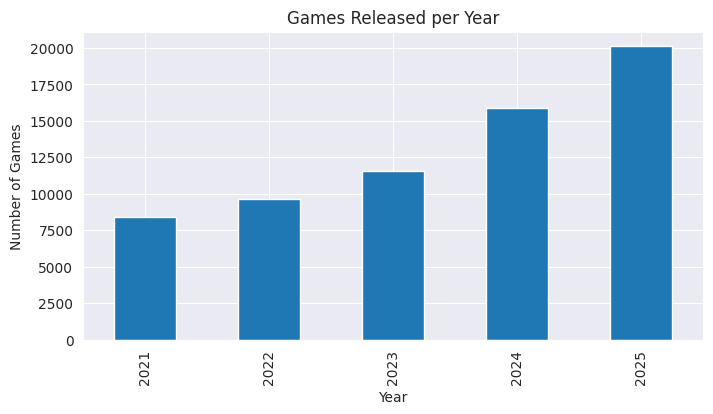

In [14]:
plt.figure(figsize=(8, 4))
counts = df["release_year"].value_counts().sort_index()
counts.plot(kind="bar")
plt.title("Games Released per Year")
plt.xlabel("Year")
plt.ylabel("Number of Games")
plt.show()


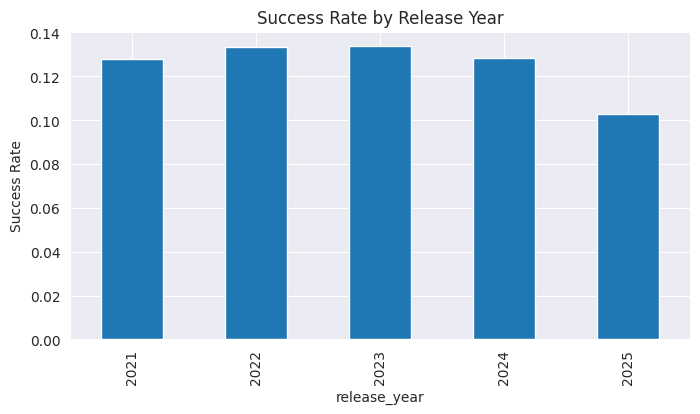

In [15]:
yearly_success = df.groupby("release_year")["successful"].mean()

yearly_success.plot(kind="bar", figsize=(8, 4))
plt.title("Success Rate by Release Year")
plt.ylabel("Success Rate")
plt.show()

## Genre Analysis

In [16]:
genres = (
    df["genres"]
    .dropna()
    .str.split(";")
    .explode()
    .str.strip()
)

top_genres = genres.value_counts().head(10)
top_genres

genres
Indie           46059
Casual          30710
Adventure       26546
Action          25720
Simulation      14514
Strategy        12995
RPG             12644
Free To Play     8043
Early Access     6920
Sports           2576
Name: count, dtype: int64

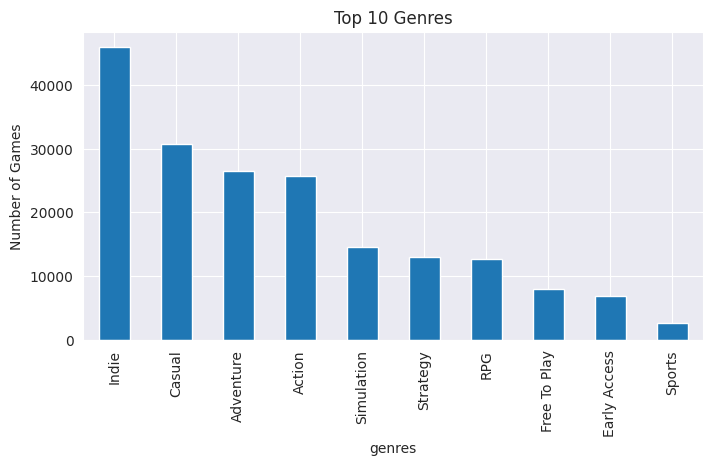

In [17]:
plt.figure(figsize=(8, 4))
top_genres.plot(kind="bar")
plt.title("Top 10 Genres")
plt.ylabel("Number of Games")
plt.show()


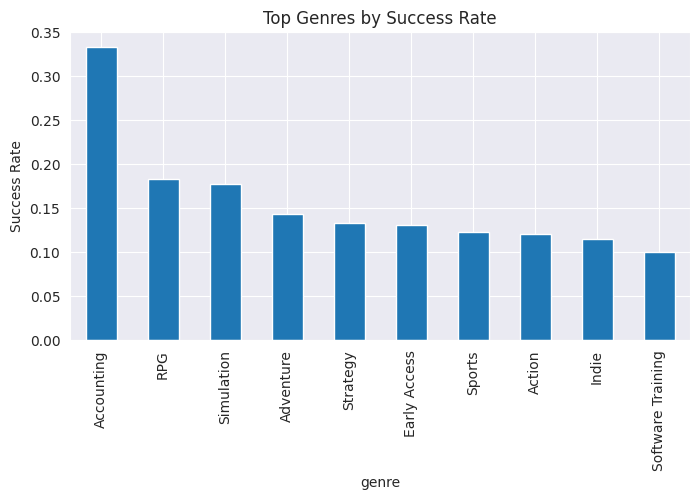

In [18]:
genre_success = (
    df.assign(genre=df["genres"].str.split(";"))
      .explode("genre")
)

genre_success["genre"] = genre_success["genre"].str.strip()
genre_success = genre_success[genre_success["genre"] != "N/A"]

genre_success_rate = (
    genre_success.groupby("genre")["successful"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
genre_success_rate.plot(kind="bar")
plt.title("Top Genres by Success Rate")
plt.ylabel("Success Rate")
plt.show()


## Category Analyis

In [19]:
categories = (
    df["categories"]
    .dropna()
    .str.split(";")
    .explode()
    .str.strip()
)

categories.value_counts().head(10)


categories
Single-player                 62908
Family Sharing                55112
Steam Achievements            31101
Steam Cloud                   16804
Full controller support       14635
Multi-player                  10356
Partial Controller Support     6625
PvP                            6432
Co-op                          6116
Custom Volume Controls         5274
Name: count, dtype: int64

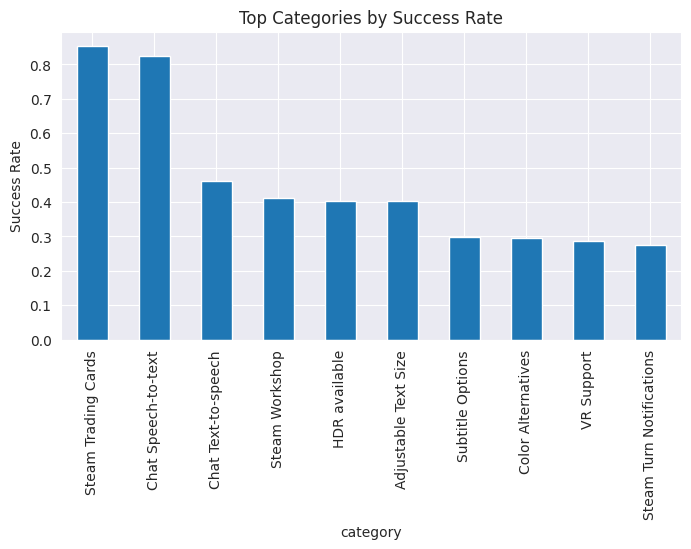

In [20]:
category_success = (
    df.assign(category=df["categories"].str.split(";"))
      .explode("category")
      .dropna(subset=["category"])
)

category_success["category"] = category_success["category"].str.strip()

category_success_rate = (
    category_success.groupby("category")["successful"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
category_success_rate.plot(kind="bar")
plt.title("Top Categories by Success Rate")
plt.ylabel("Success Rate")
plt.show()


## Developer & Publisher Analysis

In [21]:
print("Unique developers:", df["developer"].nunique())
print("Unique publishers:", df["publisher"].nunique())

Unique developers: 45680
Unique publishers: 41601


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128420 (\N{BLACK HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


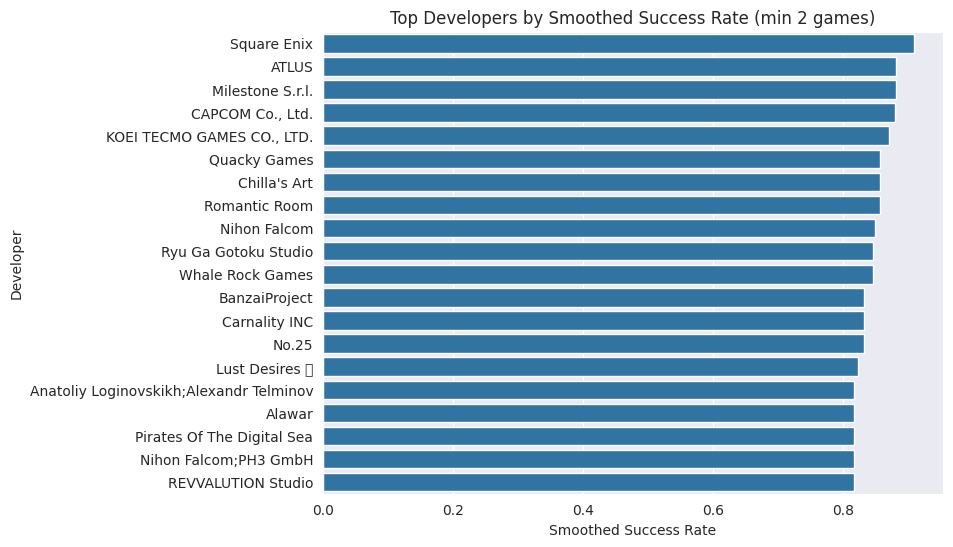

In [22]:
dev_stats = df.groupby('developer').agg(
    total_games=('successful', 'count'),
    successes=('successful', 'sum')
)
alpha = 2
dev_stats['smoothed_success_rate'] = (dev_stats['successes'] + alpha) / (dev_stats['total_games'] + 2*alpha)

dev_stats_filtered = dev_stats[dev_stats['total_games'] >= 2].sort_values('smoothed_success_rate', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x='smoothed_success_rate', y=dev_stats_filtered.index, data=dev_stats_filtered)
plt.title("Top Developers by Smoothed Success Rate (min 2 games)")
plt.xlabel("Smoothed Success Rate")
plt.ylabel("Developer")
plt.show()

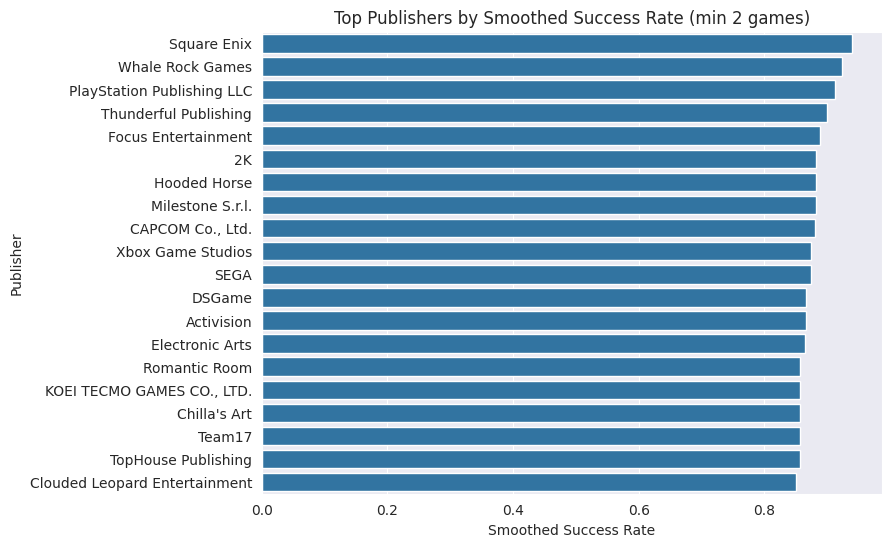

In [23]:
publisher_stats = df.groupby('publisher').agg(
    total_games=('successful', 'count'),
    successes=('successful', 'sum')
)
alpha = 2
publisher_stats['smoothed_success_rate'] = (publisher_stats['successes'] + alpha) / (publisher_stats['total_games'] + 2*alpha)

publisher_stats_filtered = publisher_stats[publisher_stats['total_games'] >= 2].sort_values('smoothed_success_rate', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x='smoothed_success_rate', y=publisher_stats_filtered.index, data=publisher_stats_filtered)
plt.title("Top Publishers by Smoothed Success Rate (min 2 games)")
plt.xlabel("Smoothed Success Rate")
plt.ylabel("Publisher")
plt.show()

# Data Preparation

## Release Date

In [24]:
dates_parsed = pd.to_datetime(df['release_date'], errors='coerce')

invalid_dates = df.loc[dates_parsed.isna(), 'release_date'].unique()

print("Invalid release_date values:")
print(invalid_dates)

Invalid release_date values:
['Q4 2025' '2025' 'December 2025']


In [25]:
def parse_release_date(date_str):

    date_str = str(date_str).strip()
    
    if date_str.upper().startswith("Q"):
        quarter, year = date_str.upper().split()
        year = int(year)
        if quarter == "Q1":
            return pd.Timestamp(year=year, month=2, day=15)
        elif quarter == "Q2":
            return pd.Timestamp(year=year, month=5, day=15)
        elif quarter == "Q3":
            return pd.Timestamp(year=year, month=8, day=15)
        elif quarter == "Q4":
            return pd.Timestamp(year=year, month=11, day=15)
    
    elif date_str.isdigit() and len(date_str) == 4:
        year = int(date_str)
        return pd.Timestamp(year=year, month=6, day=30)
    

    return pd.to_datetime(date_str)


In [26]:
df['release_date_parsed'] = df['release_date'].apply(parse_release_date)

In [27]:
df['release_month'] = df['release_date_parsed'].dt.month
df['release_day_of_week'] = df['release_date_parsed'].dt.dayofweek

## Genre and Category Multi-hot Encoding

In [28]:
genres_expanded = df['genres'].str.get_dummies(sep=';').add_prefix('genre_')
categories_expanded = df['categories'].str.get_dummies(sep=';').add_prefix('cat_')

df = pd.concat([df, genres_expanded, categories_expanded], axis=1)

In [29]:
df['num_genres'] = df['genres'].str.count(';') + 1
df['num_categories'] = df['categories'].str.count(';') + 1

df = df.drop(columns=['genres', 'categories', 'release_date', 'release_date_parsed', 'name'])

## Splitting Data

In [30]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

## Target Encoding Developer and Publisher

In [31]:
alpha = 5 
overall_mean = df_train['successful'].mean()


dev_target = df_train.groupby('developer').agg(
    successes=('successful', 'sum'),
    total=('successful', 'count')
)

dev_target['developer_encoded'] = (dev_target['successes'] + alpha * overall_mean) / (dev_target['total'] + alpha)


pub_target = df_train.groupby('publisher').agg(
    successes=('successful', 'sum'),
    total=('successful', 'count')
)
pub_target['publisher_encoded'] = (pub_target['successes'] + alpha * overall_mean) / (pub_target['total'] + alpha)

In [32]:
def encode_multi(items, mapping, overall_mean):
    items = str(items).split(';')
    encodings = [mapping.get(i, overall_mean) for i in items]
    return sum(encodings) / len(encodings)

In [33]:
df_train['developer_encoded'] = df_train['developer'].apply(
    lambda x: encode_multi(x, dev_target['developer_encoded'], overall_mean)
)
df_val['developer_encoded'] = df_val['developer'].apply(
    lambda x: encode_multi(x, dev_target['developer_encoded'], overall_mean)
)

df_train['publisher_encoded'] = df_train['publisher'].apply(
    lambda x: encode_multi(x, pub_target['publisher_encoded'], overall_mean)
)
df_val['publisher_encoded'] = df_val['publisher'].apply(
    lambda x: encode_multi(x, pub_target['publisher_encoded'], overall_mean)
)

In [34]:
df_train = df_train.drop(columns=['developer', 'publisher'])
df_val = df_val.drop(columns=['developer', 'publisher'])

### Remove Target Column

In [35]:
y_train = df_train.successful.values
y_val = df_val.successful.values
y_test = df_test.successful.values

del df_train['successful']
del df_val['successful']
del df_test['successful']

train_recs = df_train.recommendations.values
val_recs = df_val.recommendations.values
test_recs = df_test.recommendations.values

del df_train['recommendations']
del df_val['recommendations']
del df_test['recommendations']

# Train Models

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV

In [37]:
dv = DictVectorizer()

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [38]:
def precision_v_recall(pred):
    scores = []    
    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (pred >= t)
        predict_negative = (pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t, tp, fp, fn, tn))
    
    
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
    plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
    plt.legend()
    return df_scores

## Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=5000, class_weight='balanced')

log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}

log_reg_grid = GridSearchCV(log_reg, log_reg_params, scoring='roc_auc', n_jobs=-1)

log_reg_grid.fit(X_train, y_train)

best_logreg = log_reg_grid.best_estimator_
print("Best params:", log_reg_grid.best_params_)
print("Best ROC_AUC:", log_reg_grid.best_score_)

/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproc

Best params: {'C': 100}
Best ROC_AUC: 0.9880003394846897


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


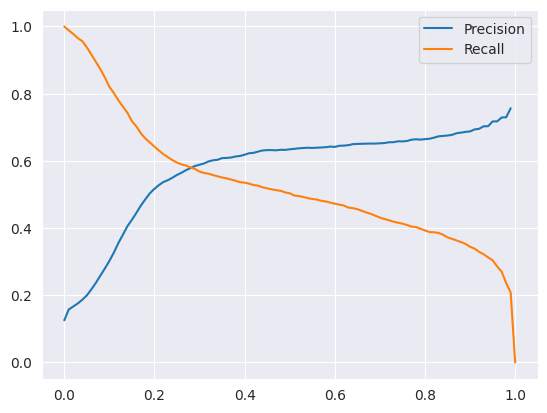

In [40]:
y_pred = best_logreg.predict_proba(X_val)[:, 1]
scores = precision_v_recall(y_pred)

In [41]:
scores[scores['threshold'].between(.10,.20)]

,threshold,tp,fp,fn,tn,p,r
10,0.10,1349,3117,295,8343,0.302060,0.820560
11,0.11,1318,2712,326,8748,0.327047,0.801703
12,0.12,1283,2326,361,9134,0.355500,0.780414
13,0.13,1252,2042,392,9418,0.380085,0.761557
14,0.14,1222,1791,422,9669,0.405576,0.743309
15,0.15,1181,1600,463,9860,0.424667,0.718370
16,0.16,1155,1438,489,10022,0.445430,0.702555
17,0.17,1121,1278,523,10182,0.467278,0.681873
18,0.18,1096,1159,548,10301,0.486031,0.666667
19,0.19,1076,1060,568,10400,0.503745,0.654501


In [42]:
success_decision = (y_pred >= 0.13)

logreg_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': round(accuracy_score(y_val, success_decision),3),
    'Precision': round(precision_score(y_val, success_decision),3),
    'Recall': round(recall_score(y_val, success_decision),3),
    'F1': round(f1_score(y_val, success_decision),3),
    'AUC': round(roc_auc_score(y_val, y_pred),3)
}
for k,v in logreg_metrics.items():
    print(f"{k}: {v}")

Model: Logistic Regression
Accuracy: 0.814
Precision: 0.38
Recall: 0.762
F1: 0.507
AUC: 0.869


## Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced', random_state=1)

dt_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_leaf': [10, 20, 30, 40]
}

dt_grid = GridSearchCV(dt, dt_params, scoring='roc_auc', n_jobs=-1)

dt_grid.fit(X_train, y_train)

best_dt = dt_grid.best_estimator_
print("Best params:", dt_grid.best_params_)
print("Best ROC_AUC:", dt_grid.best_score_)

Best params: {'max_depth': 10, 'min_samples_leaf': 40}
Best ROC_AUC: 0.9939238998365048


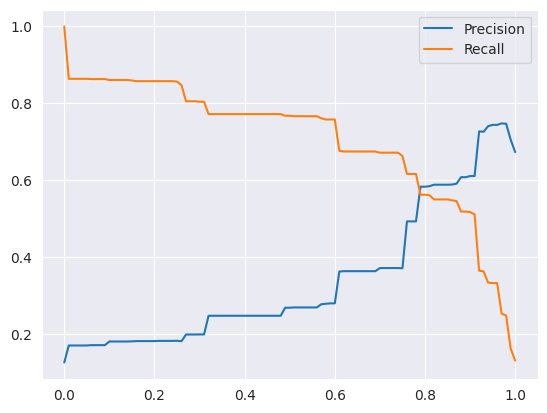

In [44]:
y_pred = best_dt.predict_proba(X_val)[:, 1]
scores = precision_v_recall(y_pred)

In [45]:
scores[scores['threshold'].between(.60,.70)]

,threshold,tp,fp,fn,tn,p,r
60,0.60,1246,3215,398,8245,0.279310,0.757908
61,0.61,1112,1959,532,9501,0.362097,0.676399
62,0.62,1109,1945,535,9515,0.363130,0.674574
63,0.63,1109,1945,535,9515,0.363130,0.674574
64,0.64,1109,1945,535,9515,0.363130,0.674574
65,0.65,1109,1945,535,9515,0.363130,0.674574
66,0.66,1109,1945,535,9515,0.363130,0.674574
67,0.67,1109,1945,535,9515,0.363130,0.674574
68,0.68,1109,1945,535,9515,0.363130,0.674574
69,0.69,1109,1945,535,9515,0.363130,0.674574


In [46]:
success_decision = (y_pred >= 0.60)

dt_metrics = {
    'Model': 'Decision Tree',
    'Accuracy': round(accuracy_score(y_val, success_decision),3),
    'Precision': round(precision_score(y_val, success_decision),3),
    'Recall': round(recall_score(y_val, success_decision),3),
    'F1': round(f1_score(y_val, success_decision),3),
    'AUC': round(roc_auc_score(y_val, y_pred),3)
}
for k,v in dt_metrics.items():
    print(f"{k}: {v}")

Model: Decision Tree
Accuracy: 0.724
Precision: 0.279
Recall: 0.758
F1: 0.408
AUC: 0.798


## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=1, n_jobs=-1)

rf_params = {
    'n_estimators': [200, 400],
    'max_depth': [None, 20, 40],
    'min_samples_leaf': [1, 5]
}

rf_grid = GridSearchCV(rf, rf_params, scoring='roc_auc', n_jobs=-1)

rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("Best params:", rf_grid.best_params_)
print("Best ROC_AUC:", rf_grid.best_score_)

/usr/local/python/3.12.1/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400}
Best ROC_AUC: 0.9944155927598167


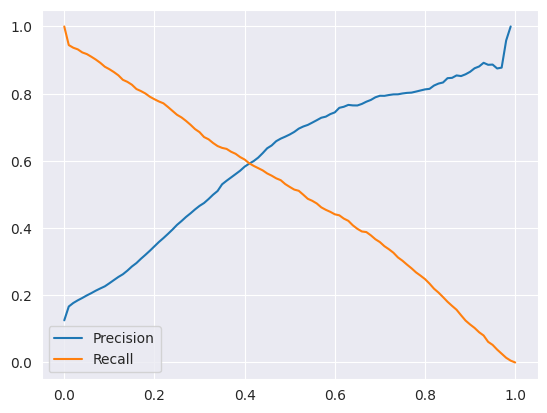

In [48]:
y_pred = best_rf.predict_proba(X_val)[:, 1]
scores = precision_v_recall(y_pred)

In [49]:
scores[scores['threshold'].between(.20,.30)]

,threshold,tp,fp,fn,tn,p,r
20,0.20,1288,2437,356,9023,0.345772,0.783455
21,0.21,1277,2283,367,9177,0.358708,0.776764
22,0.22,1268,2156,376,9304,0.370327,0.771290
23,0.23,1250,2016,394,9444,0.382731,0.760341
24,0.24,1231,1881,413,9579,0.395566,0.748783
25,0.25,1212,1748,432,9712,0.409459,0.737226
26,0.26,1199,1650,445,9810,0.420849,0.729319
27,0.27,1182,1547,462,9913,0.433126,0.718978
28,0.28,1163,1457,481,10003,0.443893,0.707421
29,0.29,1142,1365,502,10095,0.455525,0.694647


In [50]:
success_decision = (y_pred >= 0.23)

rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': round(accuracy_score(y_val, success_decision),3),
    'Precision': round(precision_score(y_val, success_decision),3),
    'Recall': round(recall_score(y_val, success_decision),3),
    'F1': round(f1_score(y_val, success_decision),3),
    'AUC': round(roc_auc_score(y_val, y_pred),3)
}
for k,v in rf_metrics.items():
    print(f"{k}: {v}")

Model: Random Forest
Accuracy: 0.816
Precision: 0.383
Recall: 0.76
F1: 0.509
AUC: 0.859


## Gradient Boosting

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=1)

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gb_grid = GridSearchCV(gb, gb_params, scoring='roc_auc', n_jobs=-1)

gb_grid.fit(X_train, y_train)

best_gb = gb_grid.best_estimator_
print("Best params:", gb_grid.best_params_)
print("Best ROC_AUC:", gb_grid.best_score_)

Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best ROC_AUC: 0.9967757633670893


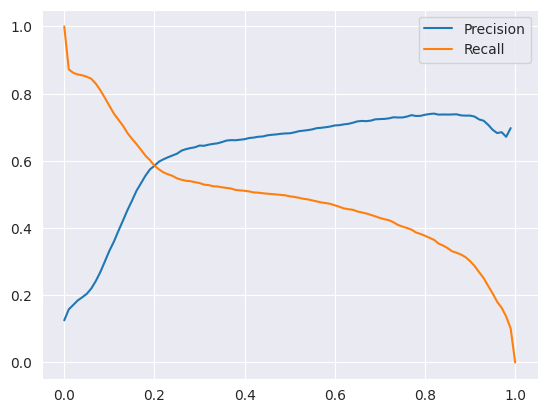

In [52]:
y_pred = best_gb.predict_proba(X_val)[:, 1]
scores = precision_v_recall(y_pred)

In [53]:
scores[scores['threshold'].between(.05,.15)]

,threshold,tp,fp,fn,tn,p,r
5,0.05,1398,5441,246,6019,0.204416,0.850365
6,0.06,1388,4913,256,6547,0.220282,0.844282
7,0.07,1364,4259,280,7201,0.242575,0.829684
8,0.08,1332,3618,312,7842,0.269091,0.810219
9,0.09,1295,3015,349,8445,0.300464,0.787713
10,0.10,1256,2525,388,8935,0.332187,0.763990
11,0.11,1218,2170,426,9290,0.359504,0.740876
12,0.12,1188,1848,456,9612,0.391304,0.722628
13,0.13,1159,1589,485,9871,0.421761,0.704988
14,0.14,1123,1356,521,10104,0.453005,0.683090


In [54]:
success_decision = (y_pred >= 0.10)

gb_metrics = {
    'Model': 'Gradient Boosting',
    'Accuracy': round(accuracy_score(y_val, success_decision),3),
    'Precision': round(precision_score(y_val, success_decision),3),
    'Recall': round(recall_score(y_val, success_decision),3),
    'F1': round(f1_score(y_val, success_decision),3),
    'AUC': round(roc_auc_score(y_val, y_pred),3)
}
for k,v in gb_metrics.items():
    print(f"{k}: {v}")

Model: Gradient Boosting
Accuracy: 0.778
Precision: 0.332
Recall: 0.764
F1: 0.463
AUC: 0.824


## Neural Network

### Dataloader

In [55]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import copy
import itertools

class SteamDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [56]:
train_ds = SteamDataset(X_train, y_train)
test_ds = SteamDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=256)

### Model

In [57]:
class SteamNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.0):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

### Training

In [58]:
def train_model(X_train_loader, X_val, y_val, input_dim, hidden_dim, lr, dropout, epochs=30):
    model = SteamNN(input_dim, hidden_dim, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in X_train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
    
    model.eval()
    X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32).to(device)
    with torch.no_grad():
        probs = torch.sigmoid(model(X_val_tensor)).cpu().numpy()
    auc = roc_auc_score(y_val, probs)
    
    return model, auc

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"

nn_params = {
    "hidden_dim": [64, 128, 256],
    "lr": [1e-2, 1e-3, 1e-4],
    "dropout": [0.0, 0.2, 0.5]
}

best_nn_auc = 0
best_nn_params = None
best_nn = None

for hidden_dim, lr, dropout in itertools.product(nn_params['hidden_dim'], nn_params['lr'], nn_params['dropout']):
    model, auc = train_model(train_loader, X_val, y_val, X_train.shape[1],hidden_dim, lr, dropout, epochs=30)
    
    if auc > best_nn_auc:
        best_nn_auc = auc
        best_nn_params = {"hidden_dim": hidden_dim, "lr": lr, "dropout": dropout}
        best_nn = copy.deepcopy(model)

print("Best Params:", best_nn_params)
print("Best ROC_AUC:", best_nn_auc)

Best Params: {'hidden_dim': 256, 'lr': 0.001, 'dropout': 0.5}
Best ROC_AUC: 0.9006009477586271


### Evaluation

In [60]:
best_nn.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        logits = best_nn(X_batch)
        probs = torch.sigmoid(logits)
        y_pred.extend(probs.squeeze().cpu().numpy())

y_pred = np.array(y_pred)

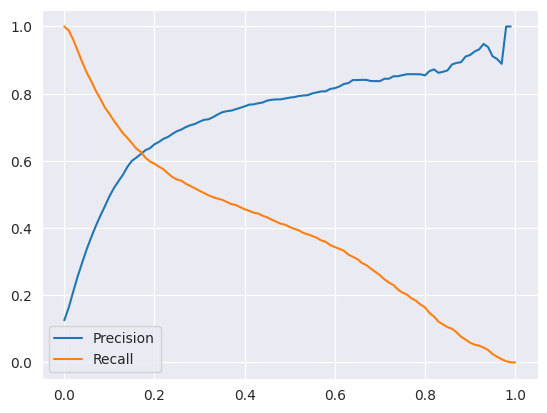

In [61]:
scores = precision_v_recall(y_pred)

In [62]:
scores[scores['threshold'].between(.05,.15)]

,threshold,tp,fp,fn,tn,p,r
5,0.05,1417,2775,227,8685,0.338025,0.861922
6,0.06,1376,2310,268,9150,0.373304,0.836983
7,0.07,1329,1940,315,9520,0.406546,0.808394
8,0.08,1290,1666,354,9794,0.436401,0.784672
9,0.09,1248,1437,396,10023,0.464804,0.759124
10,0.10,1217,1247,427,10213,0.493912,0.740268
11,0.11,1183,1097,461,10363,0.518860,0.719586
12,0.12,1153,986,491,10474,0.539037,0.701338
13,0.13,1122,887,522,10573,0.558487,0.682482
14,0.14,1099,789,545,10671,0.582097,0.668491


In [63]:
success_decision = (y_pred >= 0.09)

nn_metrics = {
    'Model': 'Neural Network',
    'Accuracy': round(accuracy_score(y_val, success_decision),3),
    'Precision': round(precision_score(y_val, success_decision),3),
    'Recall': round(recall_score(y_val, success_decision),3),
    'F1': round(f1_score(y_val, success_decision),3),
    'AUC': round(roc_auc_score(y_val, y_pred),3)
}
for k,v in nn_metrics.items():
    print(f"{k}: {v}")

Model: Neural Network
Accuracy: 0.86
Precision: 0.465
Recall: 0.759
F1: 0.577
AUC: 0.901


## Model Selection

In [64]:
df_metrics = pd.DataFrame([logreg_metrics, dt_metrics, rf_metrics, gb_metrics, nn_metrics])
df_metrics

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.814,0.380,0.762,0.507,0.869
1,Decision Tree,0.724,0.279,0.758,0.408,0.798
2,Random Forest,0.816,0.383,0.760,0.509,0.859
3,Gradient Boosting,0.778,0.332,0.764,0.463,0.824
4,Neural Network,0.860,0.465,0.759,0.577,0.901


# Feature Importance

In [65]:
def eval_auc(model, X, y):
    model.eval()
    
    X = X.toarray()

    with torch.no_grad():
        probs = torch.sigmoid(model(torch.tensor(X, dtype=torch.float32))).cpu().numpy()
        
    return roc_auc_score(y, probs)

In [66]:
baseline_auc = eval_auc(best_nn, X_val, y_val)
importances = []

for i in range(X_val.shape[1]):
    X_perm = X_val.copy()
    col = X_perm[:, i].toarray().ravel()
    np.random.shuffle(col)
    X_perm[:, i] = col.reshape(-1, 1)
    perm_auc = eval_auc(best_nn, X_perm, y_val)
    importances.append(baseline_auc - perm_auc)

In [67]:
feature_names = dv.get_feature_names_out()
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

cat = importance_df['feature'].str.startswith('cat_')
genre = importance_df['feature'].str.startswith('genre_')
category_sum = importance_df.loc[cat, 'importance'].sum()
genre_sum = importance_df.loc[genre, 'importance'].sum()

other_features = importance_df[~(cat | genre)].copy()

combined_df = pd.concat([other_features,pd.DataFrame({'feature': ['category', 'genre'],'importance': [category_sum, genre_sum]})], ignore_index=True)
combined_df = combined_df.sort_values("importance", ascending=False)
combined_df


,feature,importance
3,price,0.041462
4,publisher_encoded,0.040642
8,category,0.038203
1,num_categories,0.038127
9,genre,0.027094
0,developer_encoded,0.013349
6,release_month,0.000379
7,release_year,0.000093
5,release_day_of_week,0.000036
2,num_genres,-0.000133
